<a href="https://colab.research.google.com/github/BimsaraS99/binary-classification-pytorch/blob/main/pytorch_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***PyTorch Classification with ANN***
## ***Architecture of a classification neural network.***
Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

## ***Create sample dataset using sklearn circles***

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 X features:\n{X[:5]}, Shape: {X.shape}")
print(f"\nFirst 5 y labels:\n{y[:5]}, Shape: {y.shape}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]], Shape: (1000, 2)

First 5 y labels:
[1 1 1 1 0], Shape: (1000,)


In [ ]:
# Make DataFrame of circle data
import pandas as pd
import numpy as np

circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
print(circles.shape)
circles.sample(5)

(1000, 3)


,X1,X2,label
314,0.736627,-0.596025,0
377,0.576833,0.833382,0
320,0.551209,0.809411,0
765,-0.400062,0.660420,1
56,0.080310,0.800708,1


### ***Visualize the sample dataset on a plot***

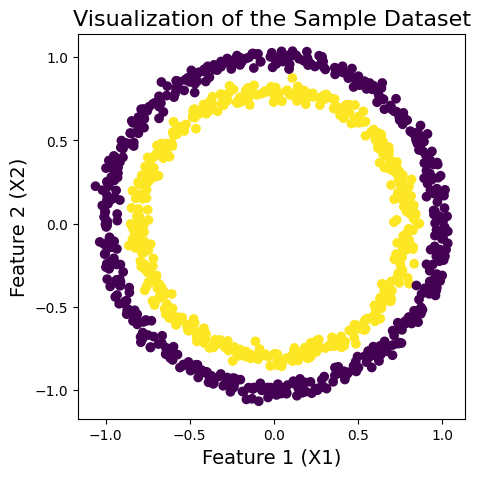

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel("Feature 1 (X1)", size=14)
plt.ylabel("Feature 2 (X2)", size=14)
plt.title("Visualization of the Sample Dataset", size=16)
plt.show()

### ***Divide features and labels of the data frame***

In [ ]:
X = circles.iloc[:, :-1].values
y = circles.iloc[:, -1].values

print("Features: ", X[:5], "\n")
print("Labels: ", y[:5])

Features:  [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 

Labels:  [1 1 1 1 0]


### ***Converting dataset to tensor, then splitting***

In [ ]:
import torch

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## ***Defining common functions***

### ***Common accuracy function***

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### ***Common training loop***

In [ ]:
def train_model(model, optimizer, loss_fn, X_train, y_train, X_test, y_test, device, epochs=1000, print_freq=100):

  X_train, y_train = X_train.to(device), y_train.to(device) # to CPU or GPU
  X_test, y_test = X_test.to(device), y_test.to(device) # to CPU or GPU

  for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze() # forward pass
    # Logits are often used to represent raw scores or unnormalized predictions generated by the last layer of a neural network.
    loss = loss_fn(y_logits, y_train) # calculate the loss using given loss function

    y_pred = torch.round(y_logits) # convert predicted probabilities in to binary
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) # calculate the accuracy
    optimizer.zero_grad() # reset the optimizer on each epoch
    loss.backward() # backward propagation
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % print_freq == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

  return model


And the use of the sigmoid activation function is not required when passing our model's raw outputs to the `nn.BCEWithLogitsLoss` (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

## ***Building models and training them with common training loop***

### ***Model V0 - ANN with two (only input and output layer) layers and without activation functions***
***Let's see whether this model can classify the circle dataset***

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device # make device agnostic code

'cpu'

***Create the model class***

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_input = nn.Linear(in_features=2, out_features=5) # input layerr
    self.layer_output = nn.Linear(in_features=5, out_features=1) # output layer

  def forward(self, x): # forward propagation
    return_value = self.layer_output(self.layer_input(x))
    return return_value

***Create an instance with the model class***

In [ ]:
model_v0 = CircleModelV0().to(device)
print(model_v0)
next(model_v0.parameters()).device
print(model_v0.state_dict())

CircleModelV0(
  (layer_input): Linear(in_features=2, out_features=5, bias=True)
  (layer_output): Linear(in_features=5, out_features=1, bias=True)
)
OrderedDict([('layer_input.weight', tensor([[-0.5969, -0.3274],
        [ 0.3267, -0.6921],
        [ 0.2970, -0.3496],
        [-0.1999,  0.2959],
        [-0.6584, -0.0642]])), ('layer_input.bias', tensor([ 0.4332,  0.0967, -0.7053,  0.3354,  0.0448])), ('layer_output.weight', tensor([[ 0.4060,  0.3197, -0.1988,  0.1881,  0.0931]])), ('layer_output.bias', tensor([-0.1770]))])


In [ ]:
with torch.inference_mode():
  untrained_preds = model_v0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.1877],
        [ 0.0070],
        [ 0.5191],
        [ 0.0944],
        [ 0.2930],
        [ 0.1844],
        [-0.1453],
        [-0.1043],
        [ 0.5282],
        [-0.0076]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


***Define loss and optimizer functions***

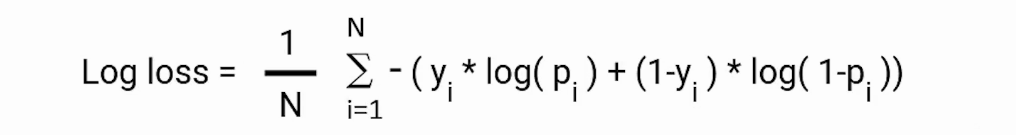

BCE vs (BCE with logits Loss) = https://www.youtube.com/watch?v=lbt0DbA7Nxk

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # Binacy Cross Entropy combined with the sigmoid function
optimizer = torch.optim.SGD(params=model_v0.parameters(), lr=0.1) # Stochastic Gradient Decent functionS

***Train the model using "train_model" function***

In [ ]:
model_v0 = train_model(
    model_v0, optimizer,
    loss_fn,
    X_train, y_train,
    X_test, y_test,
    device,
    1000,
    100
)
model_v0

Epoch: 0 | Loss: 0.70943, Accuracy: 44.62% | Test loss: 0.69788, Test acc: 54.50%
Epoch: 100 | Loss: 0.69439, Accuracy: 50.00% | Test loss: 0.69134, Test acc: 53.00%
Epoch: 200 | Loss: 0.69329, Accuracy: 50.00% | Test loss: 0.69273, Test acc: 51.00%
Epoch: 300 | Loss: 0.69305, Accuracy: 50.00% | Test loss: 0.69368, Test acc: 46.50%
Epoch: 400 | Loss: 0.69300, Accuracy: 50.00% | Test loss: 0.69419, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 50.00% | Test loss: 0.69444, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 50.00% | Test loss: 0.69457, Test acc: 45.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 50.00% | Test loss: 0.69463, Test acc: 45.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 50.00% | Test loss: 0.69466, Test acc: 45.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 50.00% | Test loss: 0.69467, Test acc: 46.00%


CircleModelV0(
  (layer_input): Linear(in_features=2, out_features=5, bias=True)
  (layer_output): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
with torch.inference_mode():
  untrained_preds = model_v0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[ 0.0280],
        [ 0.0516],
        [-0.0320],
        [ 0.0449],
        [-0.0287],
        [-0.0142],
        [ 0.0498],
        [ 0.0343],
        [-0.0320],
        [ 0.0532]])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [ ]:
with torch.inference_mode():
  trained_pred = model_v0(X_test).squeeze()
  trained_pred = torch.round(torch.sigmoid(trained_pred))
acc = accuracy_fn(y_true=y_test, y_pred=trained_pred)
print("Accuracy: ", acc, "%")

Accuracy:  46.0 %


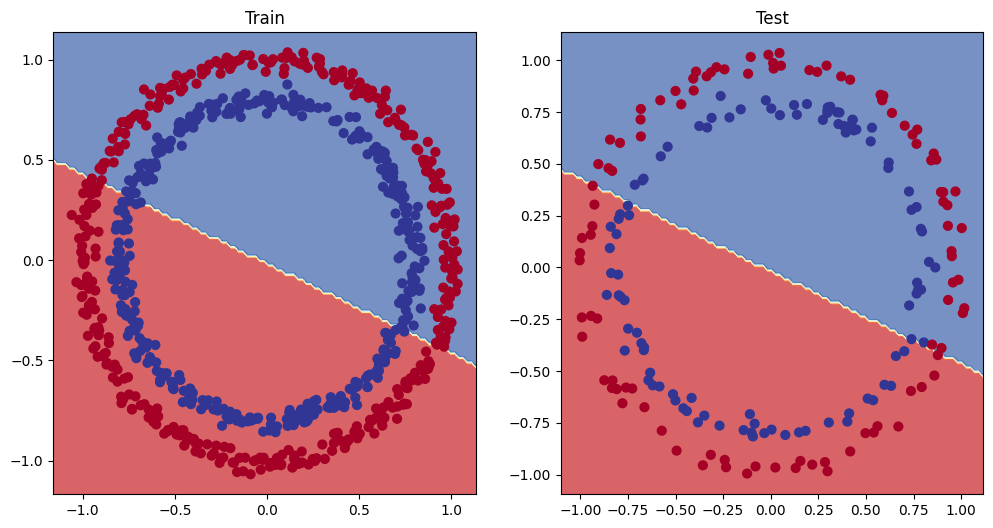

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_v0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_v0, X_test, y_test)

***As you can see in the graphs, the neural network cannot classify the dataset separately. The neural network needs to be more complex to classify the dataset, as it cannot separate it only with input and output layers. We would have to use one or two dense layers to build a accurate neural network. [Since our data is circular, drawing a straight line can at best cut it down the middle.]***



| Model improvement technique* | What does it do? |
| ----- | ----- |
| **Add more layers** | Each layer *potentially* increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network *deeper*. |
| **Add more hidden units** | Similar to the above, more hidden units per layer means a *potential* increase in learning capabilities of the model, more hidden units is often referred to as making your neural network *wider*. |
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data. |
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint). |
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough. |
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem. |
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in [notebook 06](https://www.learnpytorch.io/06_pytorch_transfer_learning/). |

> **Note:** *because you can adjust all of these by hand, they're referred to as **hyperparameters**.

### ***Model V1 - ANN with three (Include one dense layer) layers and without activation functions***
***Let's see whether this model can classify the circle dataset***

***Create a model with one hidden (dense) layer***

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

***Create a instance with the model***

In [ ]:
model_v1 = CircleModelV1().to(device)
print(model_v1)
next(model_v1.parameters()).device

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


device(type='cpu')

***Define the loss function and optimizer***

In [ ]:
loss_fn_v1 = nn.BCEWithLogitsLoss() # Binacy Cross Entropy combined with the sigmoid function
optimizer_v1 = torch.optim.SGD(params=model_v1.parameters(), lr=0.1) # Stochastic Gradient Decent functionS

In [ ]:
model_v1 = train_model(
    model_v1, optimizer_v1,
    loss_fn_v1,
    X_train, y_train,
    X_test, y_test,
    device,
    2000,
    200
)
model_v1

Epoch: 0 | Loss: 0.72500, Accuracy: 6.75% | Test loss: 0.72325, Test acc: 50.00%
Epoch: 200 | Loss: 0.68601, Accuracy: 50.00% | Test loss: 0.69130, Test acc: 47.00%
Epoch: 400 | Loss: 0.67869, Accuracy: 50.00% | Test loss: 0.68809, Test acc: 48.50%
Epoch: 600 | Loss: 0.66747, Accuracy: 49.12% | Test loss: 0.67979, Test acc: 49.00%
Epoch: 800 | Loss: 0.64288, Accuracy: 42.50% | Test loss: 0.65885, Test acc: 65.00%
Epoch: 1000 | Loss: 0.57591, Accuracy: 42.12% | Test loss: 0.59834, Test acc: 81.00%
Epoch: 1200 | Loss: 0.37712, Accuracy: 46.38% | Test loss: 0.41347, Test acc: 96.00%
Epoch: 1400 | Loss: 0.16474, Accuracy: 12.88% | Test loss: 0.21489, Test acc: 99.00%
Epoch: 1600 | Loss: 0.07153, Accuracy: 3.50% | Test loss: 0.11596, Test acc: 100.00%
Epoch: 1800 | Loss: 0.04143, Accuracy: 1.25% | Test loss: 0.07794, Test acc: 100.00%


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

***Plotting the classifer predictions***

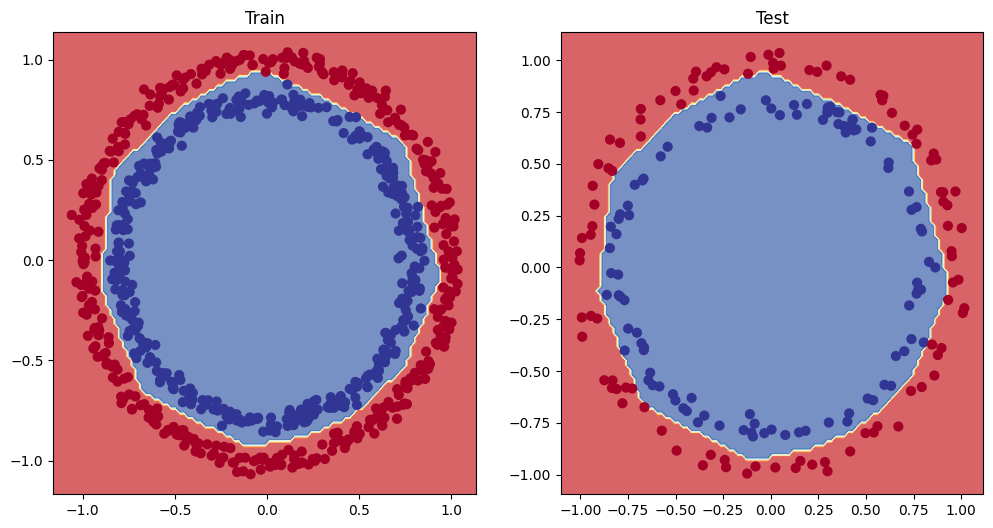

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_v1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_v1, X_test, y_test)

***As you can see, with the addition of the hidden layer, the model becomes more powerful in predicting the circular dataset very accurately.***